In [88]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
from bs4 import BeautifulSoup
from itertools import product
from tqdm import tqdm
import re
import requests
from sklearn.model_selection import train_test_split
from statistics import mean
import time
from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import warnings
from collections import Counter
import pandas as pd
import pubchempy as pcp
from sklearn.metrics import jaccard_score
from itertools import combinations
import pubchempy as pcp
from collections import Counter
import numpy as np
from sklearn.metrics import jaccard_score
import requests
from tqdm import tqdm
import pandas as pd
from statistics import mean
from bs4 import BeautifulSoup
import json
import csv
from tqdm import tqdm
import pandas as pd 
from io import StringIO
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split
import re
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
#plotting packages
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
#metrics
import math
from statistics import mean, stdev
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
# Ignore all warnings
warnings.filterwarnings('ignore')

  ### Outline
  
- [Methods](#0)
- [Loading Datasets](#1)
- [Evaluation](#3)
    - [Ratio 1:1](#3.1)
    - [Ratio 1:5](#3.2)        
    - [Ratio 1:10](#3.3)        

# 

<a name="0"></a>
**Methods**

In [89]:
def remove_labels_with_numbers(text):
    # Use a regular expression to remove numbers that appear as labels
    return re.sub(r'\d+', '', text)

In [90]:
def similarity_smile(smiles1,smiles2):
    score = 0
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # Change radius as needed
        fp2 = AllChem.GetMorganFingerprint(mol2, 2)  # Change radius as needed
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        score = tanimoto_similarity
    else:
        score = -1
    return score

In [91]:
def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Function to count k-mers
def count_kmers(kmers):
    return Counter(kmers)

# Function to calculate similarity score
def calculate_similarity(seq1, seq2, k):
    kmers_seq1 = generate_kmers(seq1, k)
    kmers_seq2 = generate_kmers(seq2, k)
    
    count_kmers_seq1 = count_kmers(kmers_seq1)
    count_kmers_seq2 = count_kmers(kmers_seq2)
    
    common_kmers = set(count_kmers_seq1.keys()) & set(count_kmers_seq2.keys())
    common_count = sum(min(count_kmers_seq1[kmer], count_kmers_seq2[kmer]) for kmer in common_kmers)
    total_count = sum(count_kmers_seq1.values()) + sum(count_kmers_seq2.values())
    
    similarity = common_count / total_count
    return similarity

In [92]:
def generate_random_combinations(num_combinations, all_drugs, all_targets, df_original):
    # Generate all possible combinations
    all_combinations = pd.MultiIndex.from_product([all_targets, all_drugs], names=['Protein', 'Drug']).to_frame(index=False)
    
    # Drop combinations that are in the original DataFrame
    filtered_combinations = all_combinations[~all_combinations.set_index(['Protein', 'Drug']).index.isin(df_original.set_index(['Protein', 'Drug']).index)]
    
    # Sample randomly from the filtered combinations
    sampled_combinations = filtered_combinations.sample(n=num_combinations, random_state=42)
    
    # Create the label column
    sampled_combinations['Label'] = 0
    
    return sampled_combinations


In [93]:
def confusionMat_v2(Y_test, y_pred, y_prob, modelName):
    cf_matrix = confusion_matrix(Y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    fpr, tpr, thresh = roc_curve(Y_test, y_prob, pos_label=1)
    auc = roc_auc_score(Y_test, y_prob)
    

    auprc = average_precision_score(Y_test, y_prob)
    precision_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])
    recall_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

    precision_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[0, 1])
    recall_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[1, 0])

    accuracy = accuracy_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print("\n", modelName, "...................................\n") 
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("AUPRC:", auprc)
    print("AUROC:", auc)
    print("PrecisionClass0:", precision_class0)
    print("RecallClass0:", recall_class0)
    print("PrecisionClass1:", precision_class1)
    print("RecallClass1:", recall_class1)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax[0])
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_test, y_pred, zero_division=1))
    return auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1,cf_matrix[1, 1]

In [94]:
columns = ['Data','AUPRC', 'AUROC', 'PrecisionClass0', 'RecallClass0', 'PrecisionClass1', 'RecallClass1', 'Accuracy', 'F1']
metricTable= pd.DataFrame(columns=columns)
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1


# 

<a name="1"></a>
**Loading Datasets**

- Mapping

In [95]:
mapping = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/drug_protein_interactions_Nuclear receptor.csv")
mapping

,Protein,Drug
0,hsa6095,D00040
1,hsa2099,D00066
2,hsa5241,D00066
3,hsa2099,D00067
4,hsa367,D00075
...,...,...
85,hsa2099,D02367
86,hsa5241,D02367
87,hsa2099,D04066
88,hsa2100,D04066


In [96]:
all_drugs = mapping['Drug'].unique().tolist()
all_targets = mapping['Protein'].unique().tolist()

- Features

In [10]:
smile_drug = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/ID_drugs_df_Nuclear receptor.csv", header=None, names=['Index', 'DrugID', 'SMILE'])
smile_drug = smile_drug.drop("Index",axis=1)
smile_drug.to_csv("../../../Dataset/Squad/NuclearReceptor/drugs_smile.csv",index=False)

In [12]:
smile_drug = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/drugs_smile.csv")
smile_drug

,DrugID,SMILE
0,D00040,[H][C@@]1(CC[C@@]2([H])[C@]3([H])CC=C4C[C@@H](...
1,D00066,[H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...
2,D00067,[H][C@@]12CCC(=O)[C@@]1(C)CC[C@]1([H])C3=C(CC[...
3,D00075,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@...
4,D00088,[H][C@@]12CC[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)...
5,D00094,C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C/C(O)=O
6,D00105,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@]1([H])C3=C(...
7,D00129,C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(...
8,D00143,[H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...
9,D00163,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@H](O)C[C@]...


In [20]:
sequence_target = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/targets_sequence.csv")
sequence_target

,TargetID,Sequence
0,hsa6095,MESAPAAPDPAASEPGSSGADAAAGSRETPLNQESARKSEPPAPVR...
1,hsa2099,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...
2,hsa5241,MTELKAKGPRAPHVAGGPPSPEVGSPLLCRPAAGPFPGSQTSDTLP...
3,hsa367,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
4,hsa2908,MDSKESLTPGREENPSSVLAQERGDVMDFYKTLRGGATVKVSASSP...
5,hsa190,MAGENHQWQGSILYNMLMSAKQTRAAPEAPETRLVDQCWGCSCGDE...
6,hsa5914,MASNSSSCPTPGGGHLNGYPVPPYAFFFPPMLGGLSPPGALTTLQH...
7,hsa5915,MTTSGHACPVPAVNGHMTHYPATPYPLLFPPVIGGLSLPPLHGLHG...
8,hsa5916,MATNKERLFAAGALGPGSGYPGAGFPFAFPGALRGSPPFEMLSPSF...
9,hsa6096,MCENQLKTKADATAQIEVIPCKICGDKSSGIHYGVITCEGCKGFFR...


**Similarity**

- Drug Similarity

In [21]:
data_drug = np.zeros((len(all_drugs), len(all_drugs)))
sim_SMILE = pd.DataFrame(data_drug, index=all_drugs, columns=all_drugs)
sim_SMILE

,D00040,D00066,D00067,D00075,D00088,D00094,D00105,D00129,D00143,D00163,...,D01161,D01217,D01294,D01387,D01441,D01689,D02217,D02367,D04066,D05341
D00040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
for id1 in tqdm(all_drugs, desc="Processing drugs smiles"):
    for id2 in all_drugs:
        smiles1 = smile_drug[smile_drug['DrugID'] == id1]['SMILE'].values[0]
        smiles2 = smile_drug[smile_drug['DrugID'] == id2]['SMILE'].values[0]
        score = similarity_smile(smiles1, smiles2)
        sim_SMILE.loc[id1][id2] = score
        sim_SMILE.loc[id2][id1] = score

sim_SMILE

Processing drugs smiles: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00, 10.36it/s]


,D00040,D00066,D00067,D00075,D00088,D00094,D00105,D00129,D00143,D00163,...,D01161,D01217,D01294,D01387,D01441,D01689,D02217,D02367,D04066,D05341
D00040,1.000000,0.378641,0.216216,0.412371,0.262712,0.113821,0.261682,0.322314,0.613636,0.435185,...,0.185185,0.279279,0.238095,0.202703,0.050847,0.211679,0.059524,0.232759,0.240310,0.048780
D00066,0.378641,1.000000,0.301075,0.757143,0.500000,0.160377,0.315217,0.186992,0.620253,0.317757,...,0.155844,0.641026,0.339623,0.291339,0.075000,0.299145,0.071895,0.264706,0.280702,0.036036
D00067,0.216216,0.301075,1.000000,0.333333,0.267327,0.115385,0.652174,0.168067,0.260417,0.165217,...,0.285714,0.273684,0.216216,0.189394,0.107383,0.218487,0.154412,0.244898,0.418367,0.028571
D00075,0.412371,0.757143,0.333333,1.000000,0.511628,0.134615,0.432099,0.205128,0.500000,0.320388,...,0.209790,0.464286,0.292453,0.282258,0.063694,0.289474,0.067114,0.291667,0.342857,0.028037
D00088,0.262712,0.500000,0.267327,0.511628,1.000000,0.140351,0.254902,0.204724,0.323529,0.275862,...,0.149068,0.377551,0.284483,0.305344,0.078313,0.407080,0.089172,0.259259,0.233871,0.051724
D00094,0.113821,0.160377,0.115385,0.134615,0.140351,1.000000,0.104762,0.146341,0.149533,0.123967,...,0.067901,0.160377,0.141667,0.143885,0.070513,0.139535,0.067114,0.097345,0.110236,0.057692
D00105,0.261682,0.315217,0.652174,0.432099,0.254902,0.104762,1.000000,0.208696,0.301075,0.229358,...,0.379032,0.287234,0.227273,0.189394,0.092715,0.218487,0.145985,0.257732,0.579545,0.018868
D00129,0.322314,0.186992,0.168067,0.205128,0.204724,0.146341,0.208696,1.000000,0.206612,0.303279,...,0.173653,0.177419,0.151079,0.166667,0.055556,0.164384,0.076923,0.195122,0.188406,0.047244
D00143,0.613636,0.620253,0.260417,0.500000,0.323529,0.149533,0.301075,0.206612,1.000000,0.382353,...,0.178808,0.471264,0.314815,0.251908,0.068323,0.245902,0.071895,0.252427,0.269565,0.045455
D00163,0.435185,0.317757,0.165217,0.320388,0.275862,0.123967,0.229358,0.303279,0.382353,1.000000,...,0.179012,0.281818,0.240000,0.212329,0.057143,0.213235,0.072727,0.193277,0.223077,0.094017


- Target Similarity 

In [23]:
data_targets = np.zeros((len(all_targets), len(all_targets)))
seq_SIM = pd.DataFrame(data_targets, index=all_targets, columns=all_targets)
seq_SIM

,hsa6095,hsa2099,hsa5241,hsa367,hsa2908,hsa190,hsa5914,hsa5915,hsa5916,hsa6096,...,hsa8856,hsa9971,hsa5465,hsa4306,hsa9970,hsa2101,hsa2103,hsa2104,hsa5468,hsa3174
hsa6095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa2908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa6096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
num_sequences = len(all_targets)
# Fill the similarity matrix
for i in tqdm(range(num_sequences), desc='Computing similarity matrix'):
    for j in range(i, num_sequences):
        seq1 = sequence_target.iloc[i]['Sequence']
        seq2 = sequence_target.iloc[j]['Sequence']
        
        # Perform global alignment
        alignments = pairwise2.align.globalxx(seq1, seq2)
        
        # Extract the alignment score (highest score)
        max_score = max(alignments, key=lambda x: x[2])[2]
        
        # Fill the matrix (symmetric matrix)
        seq_SIM.iloc[i, j] = max_score
        seq_SIM.iloc[j, i] = max_score

Computing similarity matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.23it/s]


In [25]:
seq_SIM

,hsa6095,hsa2099,hsa5241,hsa367,hsa2908,hsa190,hsa5914,hsa5915,hsa5916,hsa6096,...,hsa8856,hsa9971,hsa5465,hsa4306,hsa9970,hsa2101,hsa2103,hsa2104,hsa5468,hsa3174
hsa6095,523.0,215.0,253.0,242.0,231.0,182.0,201.0,205.0,209.0,314.0,...,193.0,205.0,211.0,255.0,167.0,189.0,203.0,198.0,223.0,171.0
hsa2099,215.0,595.0,290.0,267.0,260.0,198.0,212.0,216.0,215.0,190.0,...,188.0,220.0,208.0,281.0,161.0,217.0,246.0,234.0,216.0,177.0
hsa5241,253.0,290.0,933.0,452.0,401.0,241.0,223.0,227.0,230.0,227.0,...,220.0,239.0,233.0,456.0,196.0,224.0,245.0,237.0,240.0,213.0
hsa367,242.0,267.0,452.0,920.0,394.0,237.0,219.0,216.0,221.0,220.0,...,230.0,238.0,226.0,420.0,193.0,216.0,239.0,226.0,239.0,208.0
hsa2908,231.0,260.0,401.0,394.0,777.0,214.0,210.0,209.0,217.0,218.0,...,206.0,225.0,216.0,436.0,184.0,212.0,238.0,239.0,230.0,196.0
hsa190,182.0,198.0,241.0,237.0,214.0,470.0,161.0,163.0,161.0,175.0,...,172.0,179.0,170.0,233.0,154.0,173.0,177.0,169.0,174.0,155.0
hsa5914,201.0,212.0,223.0,219.0,210.0,161.0,462.0,370.0,346.0,189.0,...,185.0,196.0,193.0,226.0,156.0,174.0,202.0,187.0,198.0,166.0
hsa5915,205.0,216.0,227.0,216.0,209.0,163.0,370.0,455.0,352.0,188.0,...,187.0,193.0,191.0,231.0,160.0,172.0,201.0,188.0,199.0,168.0
hsa5916,209.0,215.0,230.0,221.0,217.0,161.0,346.0,352.0,454.0,188.0,...,183.0,196.0,194.0,231.0,157.0,175.0,205.0,190.0,196.0,166.0
hsa6096,314.0,190.0,227.0,220.0,218.0,175.0,189.0,188.0,188.0,470.0,...,190.0,182.0,186.0,233.0,163.0,168.0,187.0,176.0,200.0,168.0


In [26]:
k=1
kmer_1_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_1_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 42.59it/s]


In [27]:
k=2
kmer_2_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_2_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 35.32it/s]


In [28]:
k=3
kmer_3_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_3_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 36.10it/s]


In [29]:
k=4
kmer_4_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_4_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.35it/s]


In [30]:
#Save Similarities
sim_SMILE.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/smile_similarity.csv")
seq_SIM.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/seq_SIM.csv")
kmer_1_similarity.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_1_similarity.csv")
kmer_2_similarity.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_2_similarity.csv")
kmer_3_similarity.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_3_similarity.csv")
kmer_4_similarity.to_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_4_similarity.csv")

In [97]:
#Load Similarities
sim_SMILE = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/smile_similarity.csv")
default_protein     = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/nr_simmat_dg.txt", delimiter='\t')

#SIMMAT
HLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/HLCS_nr_simmat_dc.txt' , sep='\t')
NLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/NLCS_nr_simmat_dc.txt' , sep='\t')
TFIDF_simmat_simmat_dc = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/TFIDF_nr_simmat_dc.txt' , sep='\t')
TF_simmat_simmat_dc    = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/TF_nr_simmat_dc.txt' , sep='\t')
complingo4_simmat_dc   = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/complingo4_nr_simmat_dc.txt' , sep='\t')
comptfidf_simmat_dc    = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/comptfidf_nr_simmat_dc.txt' , sep='\t')
edit_simmat_dc         = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/edit_nr_simmat_dc.txt' , sep='\t')
lingo3_simmat_dc       = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/lingo3_nr_simmat_dc.txt' , sep='\t')
lingo4_simmat_dc       = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/lingo4_nr_simmat_dc.txt' , sep='\t')
lingo5_simmat_dc       = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/lingo5_nr_simmat_dc.txt' , sep='\t')
smifp34Man             = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/smifp34Man_nr_simmat_dc.txt' , sep='\t')
smifp34Tan             = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/smifp34Tan_nr_simmat_dc.txt' , sep='\t')
smifp38Man             = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/smifp38Man_nr_simmat_dc.txt' , sep='\t')
smifp38Tan             = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/smifp38Tan_nr_simmat_dc.txt' , sep='\t')
substring              = pd.read_csv('../../../Dataset/Squad/NuclearReceptor/Features/substring_nr_simmat_dc.txt' , sep='\t')

seq_SIM   = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/seq_SIM.csv")
kmer_1_similarity = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_1_similarity.csv")
kmer_2_similarity = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_2_similarity.csv")
kmer_3_similarity = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_3_similarity.csv")
kmer_4_similarity = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/kmer_4_similarity.csv")
default_compound   = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/nr_admat_dgc.txt", delimiter='\t')
nt_similarity = pd.read_csv("../../../Dataset/Squad/NuclearReceptor/Features/NT_Similarities.csv")
nt_similarity.columns = [col.replace(':', '') for col in nt_similarity.columns]
nt_similarity['KEGG ID'] = nt_similarity['KEGG ID'].str.replace(':', '')

# 

<a name="3"></a>
### Evaluation

In [98]:
print("Dataset NuclearReceptor with ", len(all_drugs) , " drugs and " , len(all_targets) , "targets including", len(mapping))

Dataset NuclearReceptor with  54  drugs and  26 targets including 90


In [99]:
#Random Negative Sampling 
mapping

,Protein,Drug
0,hsa6095,D00040
1,hsa2099,D00066
2,hsa5241,D00066
3,hsa2099,D00067
4,hsa367,D00075
...,...,...
85,hsa2099,D02367
86,hsa5241,D02367
87,hsa2099,D04066
88,hsa2100,D04066


<a name="3.1"></a>
### Ratio 1:1  
- [Evaluatuin](#3.1.0)
- [Feature Selection](#3.1.1)

In [146]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 1
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa6095,D00040,1
1,1,hsa2099,D00066,1
2,2,hsa5241,D00066,1
3,3,hsa2099,D00067,1
4,4,hsa367,D00075,1
...,...,...,...,...
175,175,hsa2908,D00348,0
176,176,hsa5914,D00182,0
177,177,hsa5915,D00586,0
178,178,hsa6258,D00577,0


In [147]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [148]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
#                                     "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,          
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,kmer1_mean,NT_max,NT_mean,default_protein_max,default_protein_mean,default_compound_max,default_compound_mean,count_drug,count_target,target


In [149]:
for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
#     comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
#     comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0

    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
#         comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
#         comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
#                     comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


180it [00:05, 34.83it/s]                                                                                                                                   


In [150]:
df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


In [105]:
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00040,hsa6095,0.050847,0.050847,0.02863,0.028630,0.08500,0.085000,0.00000,...,0.085,0.0,0.0,0.064516,0.128205,0.030303,0.0,0.0,0.01333,0.29333
1,1,D00066,hsa2099,0.417582,0.257334,0.34623,0.160716,0.70110,0.426492,0.46736,...,4.69141,2.28012,5.89532,3.551315,5.42222,3.832018,3.17339,2.674588,1.24224,7.40226
2,2,D00066,hsa5241,0.641026,0.359105,0.43944,0.248495,0.95455,0.636230,0.52180,...,5.08984,2.76873,5.90841,4.021993,5.192696,4.276725,3.65861,3.101118,1.81769,6.74594
3,3,D00067,hsa2099,0.689189,0.327496,0.75479,0.261409,0.82793,0.467945,0.82346,...,5.14739,3.21687,6.43525,4.471054,6.037371,4.635868,4.25479,3.889738,0.59577,7.17231
4,4,D00075,hsa367,0.476190,0.307254,0.46706,0.222226,0.77356,0.509368,0.40774,...,2.54684,1.10515,3.01875,2.079897,2.86522,2.188013,1.89807,1.659276,0.44949,3.42458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,D00348,hsa2908,0.143885,0.133928,0.07517,0.069710,0.22528,0.207780,0.03910,...,0.83112,0.09619,0.27087,0.367046,1.227053,0.346673,0.13113,0.008197,0.14952,1.50168
176,176,D00182,hsa5914,0.110092,0.086518,0.06429,0.061303,0.19149,0.180643,0.01175,...,0.54193,0.02574,0.12304,0.175299,0.859375,0.215836,0.07291,0.011364,0.1275,1.10247
177,177,D00586,hsa5915,0.069307,0.069307,0.06368,0.063680,0.17862,0.178620,0.02121,...,0.17862,0.02121,0.05617,0.036606,0.234043,0.049751,0.02193,0.012821,0.02632,0.32121
178,178,D00577,hsa6258,0.198113,0.119527,0.15592,0.108660,0.43554,0.309233,0.07221,...,0.9277,0.18097,0.34541,0.407185,1.141811,0.439275,0.15171,0.060606,0.16787,1.75252


In [106]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

In [107]:
df_scores.columns

Index(['index', 'drugID', 'targetID', 'smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'edit_max', 'edit_mean', 'lingo3_max', 'lingo3_mean',
       'lingo4_max', 'lingo4_mean', 'lingo5_max', 'lingo5_mean',
       'smifp34Man_max', 'smifp34Man_mean', 'smifp34Tan_max',
       'smifp34Tan_mean', 'smifp38Man_max', 'smifp38Man_mean',
       'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max', 'substring_mean',
       'target_align_score_max', 'target_align_score_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj

In [108]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'edit_max', 'edit_mean', 'lingo3_max', 'lingo3_mean',
       'lingo4_max', 'lingo4_mean', 'lingo5_max', 'lingo5_mean',
       'smifp34Man_max', 'smifp34Man_mean', 'smifp34Tan_max',
       'smifp34Tan_mean', 'smifp38Man_max', 'smifp38Man_mean',
       'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max', 'substring_mean',
       'target_align_score_max', 'target_align_score_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_NT_max', 'adj_default_protein_max',
       'adj_default_compound_max', 'adj_HLCS_max', 'adj_NLCS_max',
       'adj_TFIDF_simmat_max', 'adj_TF_simmat_max', 'adj_complingo_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  NuclearReceptor 1:1

 RandomForest ...................................

Accuracy: 0.8611111111111112
F1-Score: 0.8571428571428571
AUPRC: 0.9547254760490054
AUROC: 0.9521604938271605
PrecisionClass0: 0.8421052631578947
RecallClass0: 0.8888888888888888
PrecisionClass1: 0.8823529411764706
RecallClass1: 0.8333333333333334


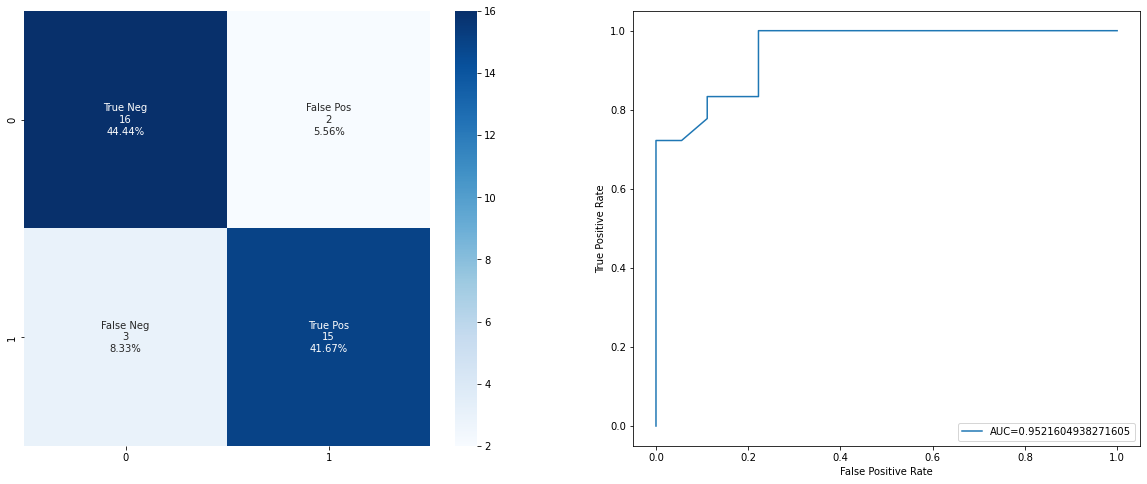

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.88      0.83      0.86        18

    accuracy                           0.86        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.86      0.86      0.86        36



In [109]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:1'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

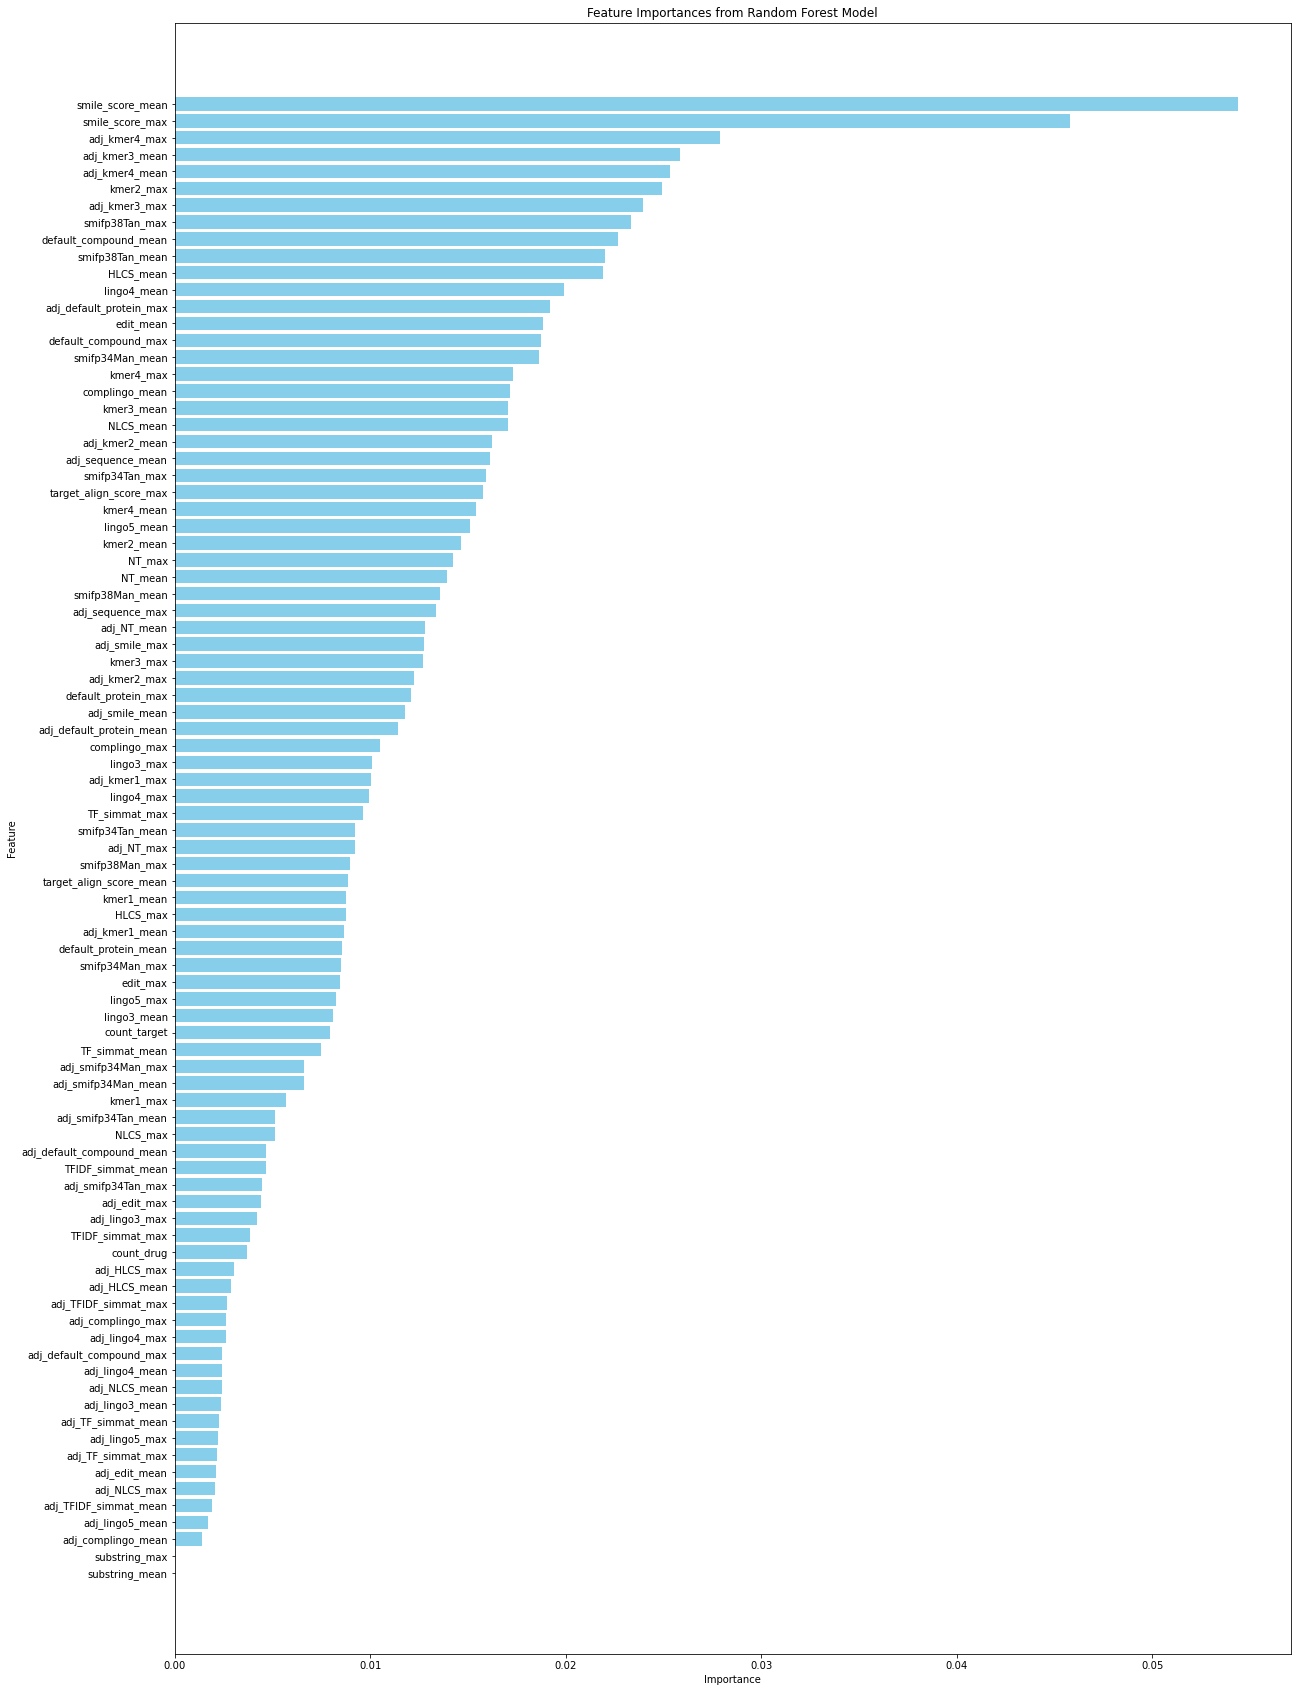

In [110]:
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 30))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# 

<a name="3.1.1"></a>
**Feature Selection**

In [86]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: kmer4_mean - Accuracy: 0.9166666666666666
Added feature: smifp38Tan_max - Accuracy: 0.9444444444444444
Added feature: adj_HLCS_max - Accuracy: 1.0
Selected features: ['kmer4_mean', 'smifp38Tan_max', 'adj_HLCS_max']
Final Accuracy with selected features: 1.0


Results of  NuclearReceptor 1:1 topFeatures

 RandomForest ...................................

Accuracy: 0.9444444444444444
F1-Score: 0.9473684210526316
AUPRC: 0.9809141249092229
AUROC: 0.9830246913580246
PrecisionClass0: 1.0
RecallClass0: 0.8888888888888888
PrecisionClass1: 0.9
RecallClass1: 1.0


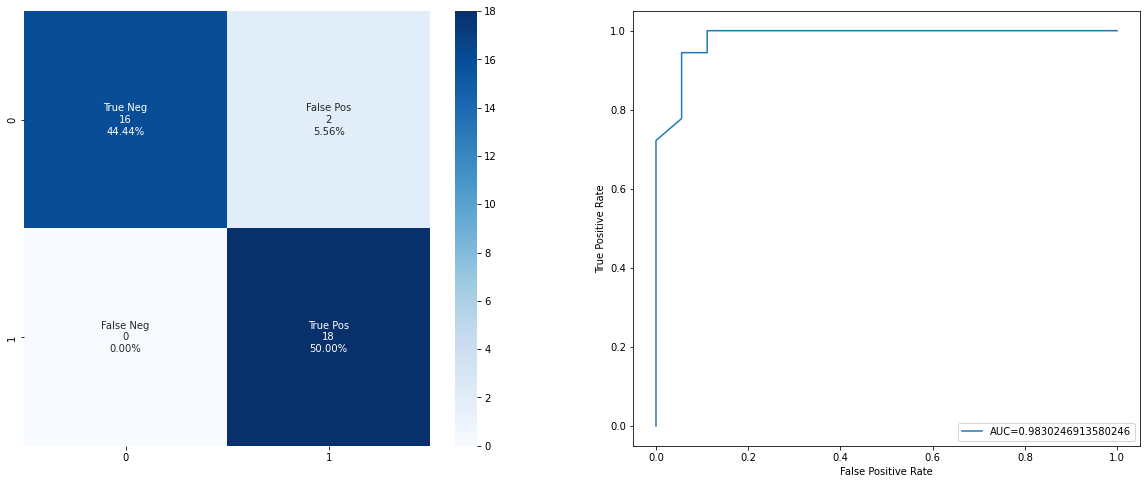

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.90      1.00      0.95        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



In [111]:
top_features = ['kmer4_mean', 'smifp38Tan_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:1 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [153]:
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1
0,NuclearReceptor 1:1,0.954725,0.952160,0.842105,0.888889,0.882353,0.833333,0.861111,0.857143
1,NuclearReceptor 1:1 topFeatures,0.980914,0.983025,1.000000,0.888889,0.900000,1.000000,0.944444,0.947368
2,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
3,NuclearReceptor 1:5 topFeatures,0.831559,0.879911,0.908046,0.987500,0.952381,0.714286,0.916667,0.816327
4,NuclearReceptor 1:10,0.842116,0.971489,0.951613,0.994382,0.916667,0.550000,0.949495,0.687500
5,NuclearReceptor 1:10 topFeatures,0.872455,0.955056,0.967213,0.994382,0.933333,0.700000,0.964646,0.800000
6,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
7,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
8,NuclearReceptor 1:5 topFeatures2,0.915753,0.934598,0.879121,1.000000,1.000000,0.607143,0.898148,0.755556


In [152]:
columns = ['Model','AUPRC', 'AUROC', 'Accuracy']
metricTableClassification = pd.DataFrame(columns=columns)
metricTableClassification

,Model,AUPRC,AUROC,Accuracy


In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc
import pandas as pd

Results of KNN

 KNN ...................................

Accuracy: 0.7685185185185185
F1-Score: 0.358974358974359
AUPRC: 0.5462344533773105
AUROC: 0.8008928571428571
PrecisionClass0: 0.7835051546391752
RecallClass0: 0.95
PrecisionClass1: 0.6363636363636364
RecallClass1: 0.25


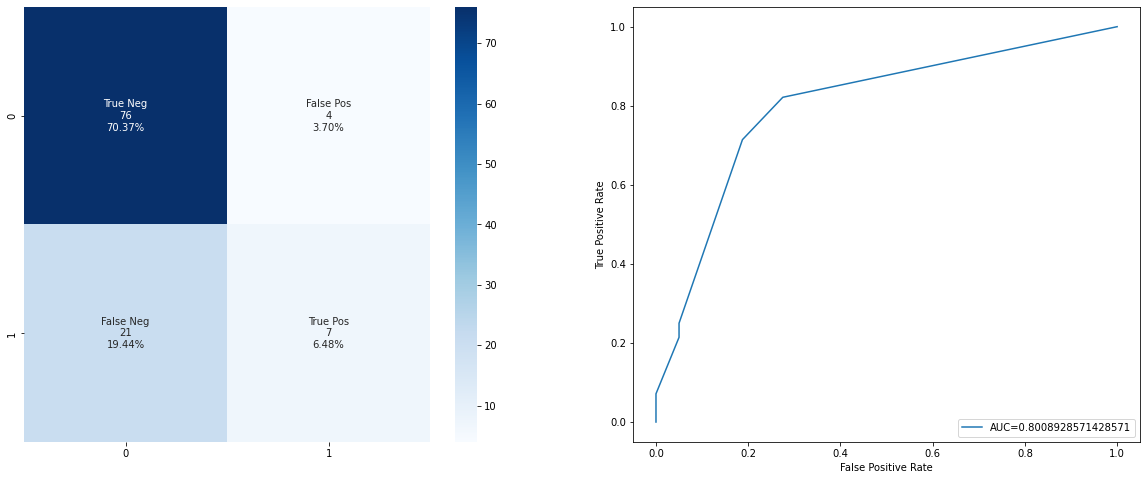

              precision    recall  f1-score   support

           0       0.78      0.95      0.86        80
           1       0.64      0.25      0.36        28

    accuracy                           0.77       108
   macro avg       0.71      0.60      0.61       108
weighted avg       0.75      0.77      0.73       108

Results of Logistic Regression

 Logistic Regression ...................................

Accuracy: 0.7407407407407407
F1-Score: 0.0
AUPRC: 0.4983763778461545
AUROC: 0.6060267857142858
PrecisionClass0: 0.7407407407407407
RecallClass0: 1.0
PrecisionClass1: nan
RecallClass1: 0.0


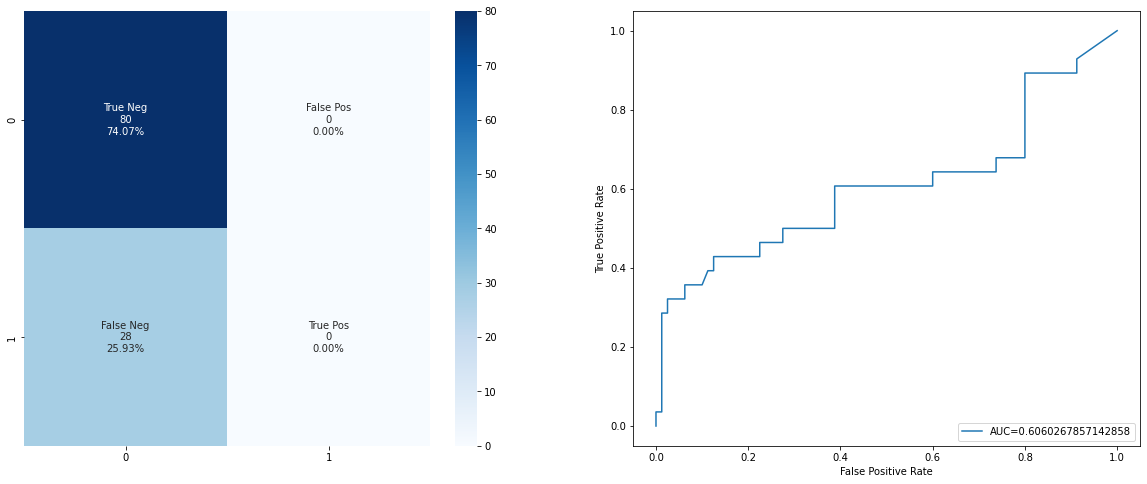

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        80
           1       1.00      0.00      0.00        28

    accuracy                           0.74       108
   macro avg       0.87      0.50      0.43       108
weighted avg       0.81      0.74      0.63       108

Results of MLP Model 1

 MLP Model 1 ...................................

Accuracy: 0.7685185185185185
F1-Score: 0.24242424242424243
AUPRC: 0.5257171502984839
AUROC: 0.6243303571428571
PrecisionClass0: 0.7669902912621359
RecallClass0: 0.9875
PrecisionClass1: 0.8
RecallClass1: 0.14285714285714285


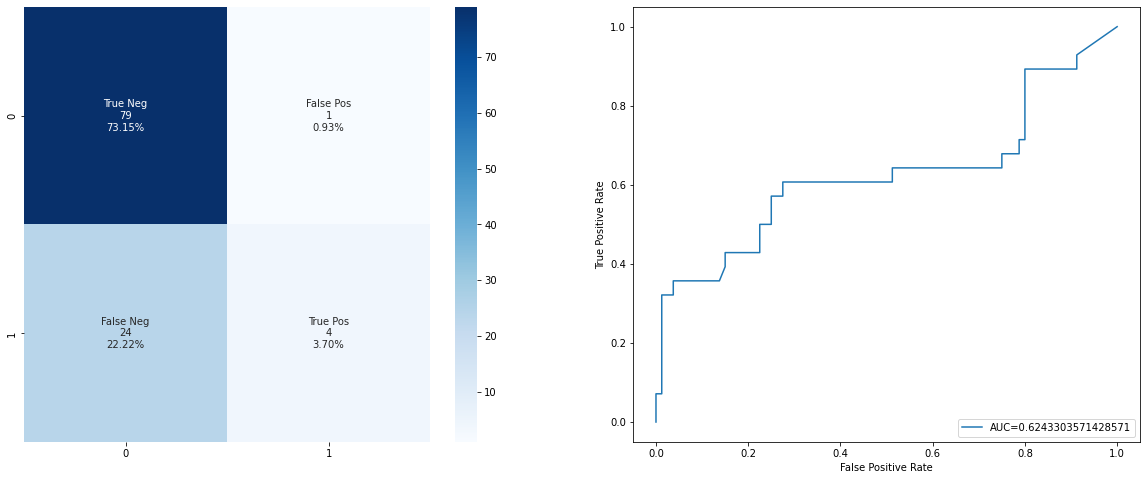

              precision    recall  f1-score   support

           0       0.77      0.99      0.86        80
           1       0.80      0.14      0.24        28

    accuracy                           0.77       108
   macro avg       0.78      0.57      0.55       108
weighted avg       0.78      0.77      0.70       108

Results of MLP Model 2

 MLP Model 2 ...................................

Accuracy: 0.7870370370370371
F1-Score: 0.46511627906976744
AUPRC: 0.6349805427697784
AUROC: 0.7897321428571429
PrecisionClass0: 0.8064516129032258
RecallClass0: 0.9375
PrecisionClass1: 0.6666666666666666
RecallClass1: 0.35714285714285715


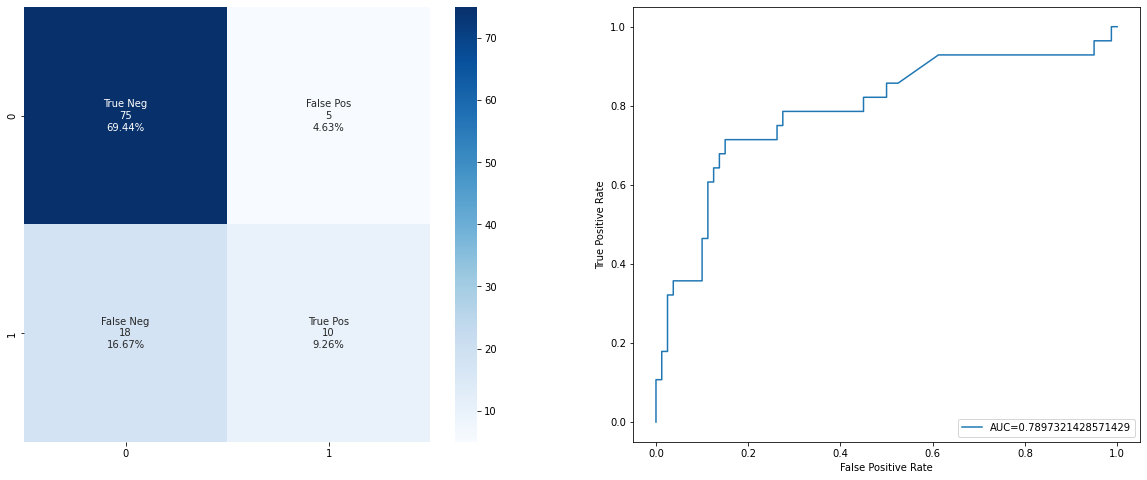

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        80
           1       0.67      0.36      0.47        28

    accuracy                           0.79       108
   macro avg       0.74      0.65      0.67       108
weighted avg       0.77      0.79      0.76       108

Results of Decision Tree

 Decision Tree ...................................

Accuracy: 0.8425925925925926
F1-Score: 0.6382978723404255
AUPRC: 0.568151529617695
AUROC: 0.7564732142857143
PrecisionClass0: 0.8539325842696629
RecallClass0: 0.95
PrecisionClass1: 0.7894736842105263
RecallClass1: 0.5357142857142857


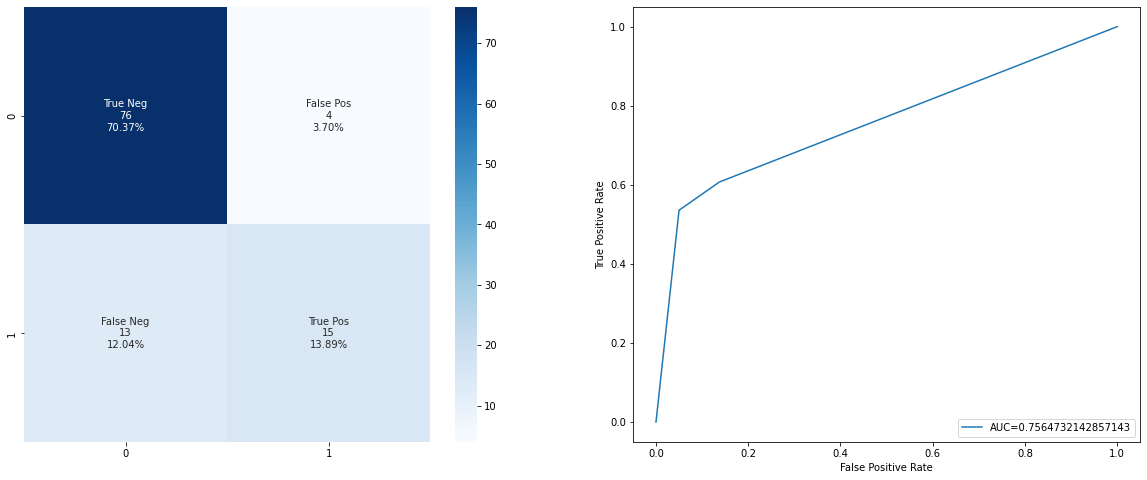

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        80
           1       0.79      0.54      0.64        28

    accuracy                           0.84       108
   macro avg       0.82      0.74      0.77       108
weighted avg       0.84      0.84      0.83       108

Results of Random Forest

 Random Forest ...................................

Accuracy: 0.8240740740740741
F1-Score: 0.5581395348837209
AUPRC: 0.658018452346298
AUROC: 0.846875
PrecisionClass0: 0.8279569892473119
RecallClass0: 0.9625
PrecisionClass1: 0.8
RecallClass1: 0.42857142857142855


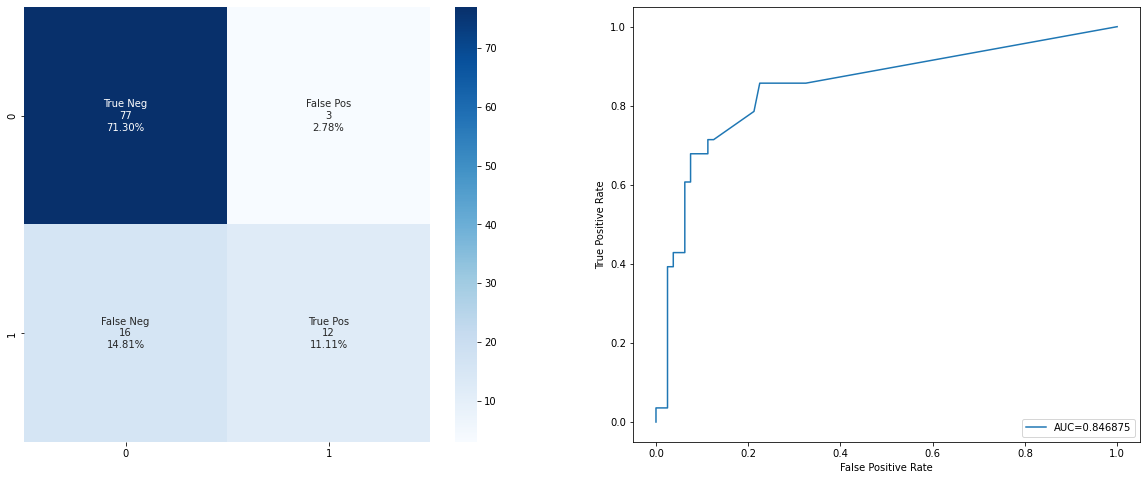

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        80
           1       0.80      0.43      0.56        28

    accuracy                           0.82       108
   macro avg       0.81      0.70      0.72       108
weighted avg       0.82      0.82      0.80       108



,Model,AUPRC,AUROC,Accuracy
0,KNN,0.546234,0.800893,0.768519
1,Logistic Regression,0.498376,0.606027,0.740741
2,MLP Model 1,0.525717,0.624330,0.768519
3,MLP Model 2,0.634981,0.789732,0.787037
4,Decision Tree,0.568152,0.756473,0.842593
5,Random Forest,0.642846,0.853125,0.824074
6,KNN,0.546234,0.800893,0.768519
7,Logistic Regression,0.498376,0.606027,0.740741
8,MLP Model 1,0.525717,0.624330,0.768519
9,MLP Model 2,0.634981,0.789732,0.787037


In [159]:
top_features = ['kmer4_mean', 'smifp38Tan_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)

# List of models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Model 1': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP Model 2': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42)
}



data_name = 'NuclearReceptor 1:1 topFeatures'

for model_name, model in models.items():
    print(f"Results of {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auprc, auc_score, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, tp = confusionMat_v2(y_test, y_pred, y_prob,model_name)
    
    # Save results
    df_list = [model_name, auprc, auc_score, accuracy]
    metricTableClassification.loc[len(metricTableClassification)] = df_list

metricTableClassification

# 

<a name="3.2"></a>
### Ratio 1:5  
- [Evaluatuin](#3.2.0)
- [Feature Selection](#3.2.1)

In [134]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 5
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa6095,D00040,1
1,1,hsa2099,D00066,1
2,2,hsa5241,D00066,1
3,3,hsa2099,D00067,1
4,4,hsa367,D00075,1
...,...,...,...,...
535,535,hsa6096,D00163,0
536,536,hsa2101,D00279,0
537,537,hsa5914,D00962,0
538,538,hsa6257,D00965,0


In [135]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [136]:
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
#                                     "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,          
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])
df_scores


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,kmer1_mean,NT_max,NT_mean,default_protein_max,default_protein_mean,default_compound_max,default_compound_mean,count_drug,count_target,target


In [137]:
for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
#     comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
#     comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0

    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
#         comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
#         comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
#                     comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores



540it [00:19, 27.36it/s]                                                                                                                                   


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00040,hsa6095,0.050847,0.050847,0.02863,0.028630,0.08500,0.085000,0.00000,...,0.085,0.0,0.0,0.064516,0.128205,0.030303,0.0,0.0,0.01333,0.29333
1,1,D00066,hsa2099,0.417582,0.231674,0.34623,0.143792,0.70110,0.380727,0.46736,...,4.56873,2.17148,5.38138,3.374017,5.386811,3.547829,2.92878,2.479298,1.25271,7.499
2,2,D00066,hsa5241,0.443299,0.345130,0.24144,0.221043,0.66032,0.576732,0.42692,...,3.46039,1.99968,4.27642,2.876024,3.585688,2.846413,2.44417,2.087399,1.09821,4.83352
3,3,D00067,hsa2099,0.689189,0.299964,0.75479,0.239503,0.82793,0.435787,0.82346,...,5.22945,3.2486,6.12931,4.333823,6.256712,4.372007,3.94245,3.618579,0.64186,7.37139
4,4,D00075,hsa367,0.476190,0.224997,0.22883,0.119872,0.63519,0.329730,0.28841,...,1.97838,0.70307,2.26262,1.602688,2.525221,1.65574,1.33391,1.081489,0.42069,3.12661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,535,D00163,hsa6096,0.096296,0.096296,0.03886,0.038860,0.11214,0.112140,0.02630,...,0.11214,0.0263,0.02012,0.058414,0.218391,0.055556,0.01266,0.0,0.01887,0.3436
536,536,D00279,hsa2101,0.178571,0.178571,0.16797,0.167970,0.46667,0.466670,0.06253,...,0.46667,0.06253,0.19647,0.197677,0.542857,0.125,0.06202,0.030303,0.11111,0.85556
537,537,D00962,hsa5914,0.087719,0.073955,0.09858,0.072167,0.28688,0.207547,0.05320,...,0.62264,0.13226,0.27029,0.225029,0.90411,0.28877,0.10983,0.047373,0.08571,1.51618
538,538,D00965,hsa6257,0.085470,0.079772,0.06581,0.064820,0.18398,0.183240,0.04312,...,0.36648,0.04403,0.11038,0.138429,0.44721,0.166828,0.06083,0.035577,0.06071,0.71668


Results of  NuclearReceptor 1:5

 RandomForest ...................................

Accuracy: 0.8888888888888888
F1-Score: 0.75
AUPRC: 0.8429331182118041
AUROC: 0.897544642857143
PrecisionClass0: 0.8863636363636364
RecallClass0: 0.975
PrecisionClass1: 0.9
RecallClass1: 0.6428571428571429


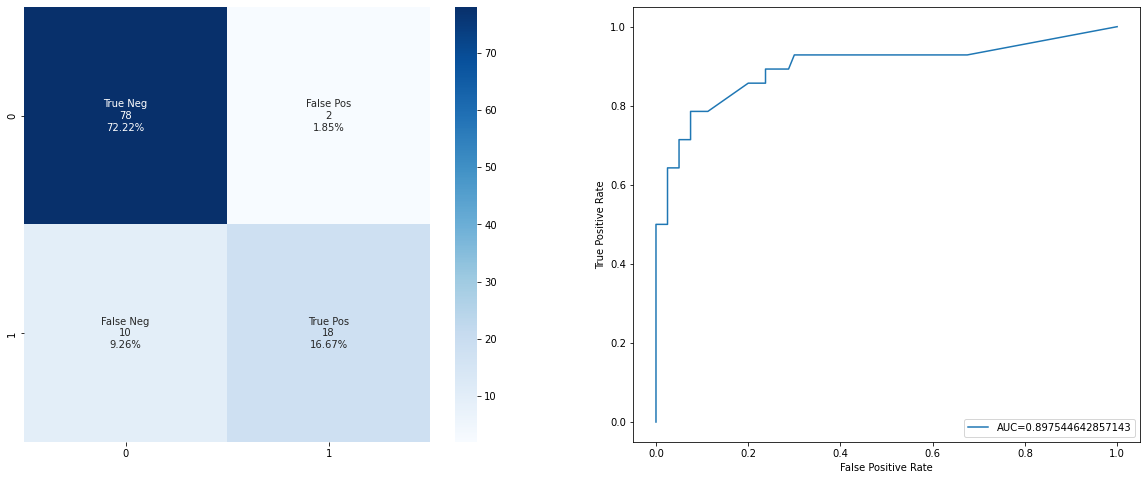

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        80
           1       0.90      0.64      0.75        28

    accuracy                           0.89       108
   macro avg       0.89      0.81      0.84       108
weighted avg       0.89      0.89      0.88       108



In [138]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'edit_max', 'edit_mean', 'lingo3_max', 'lingo3_mean',
       'lingo4_max', 'lingo4_mean', 'lingo5_max', 'lingo5_mean',
       'smifp34Man_max', 'smifp34Man_mean', 'smifp34Tan_max',
       'smifp34Tan_mean', 'smifp38Man_max', 'smifp38Man_mean',
       'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max', 'substring_mean',
       'target_align_score_max', 'target_align_score_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_NT_max', 'adj_default_protein_max',
       'adj_default_compound_max', 'adj_HLCS_max', 'adj_NLCS_max',
       'adj_TFIDF_simmat_max', 'adj_TF_simmat_max', 'adj_complingo_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

# 

<a name="3.2.1"></a>
**Feature Selection**

In [120]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: adj_kmer3_mean - Accuracy: 0.8425925925925926
Added feature: adj_default_compound_max - Accuracy: 0.9074074074074074
Added feature: smifp38Man_max - Accuracy: 0.9166666666666666
Selected features: ['adj_kmer3_mean', 'adj_default_compound_max', 'smifp38Man_max']
Final Accuracy with selected features: 0.9166666666666666


Results of  NuclearReceptor 1:5 topFeatures

 RandomForest ...................................

Accuracy: 0.9166666666666666
F1-Score: 0.8163265306122449
AUPRC: 0.8315594974189365
AUROC: 0.8799107142857143
PrecisionClass0: 0.9080459770114943
RecallClass0: 0.9875
PrecisionClass1: 0.9523809523809523
RecallClass1: 0.7142857142857143


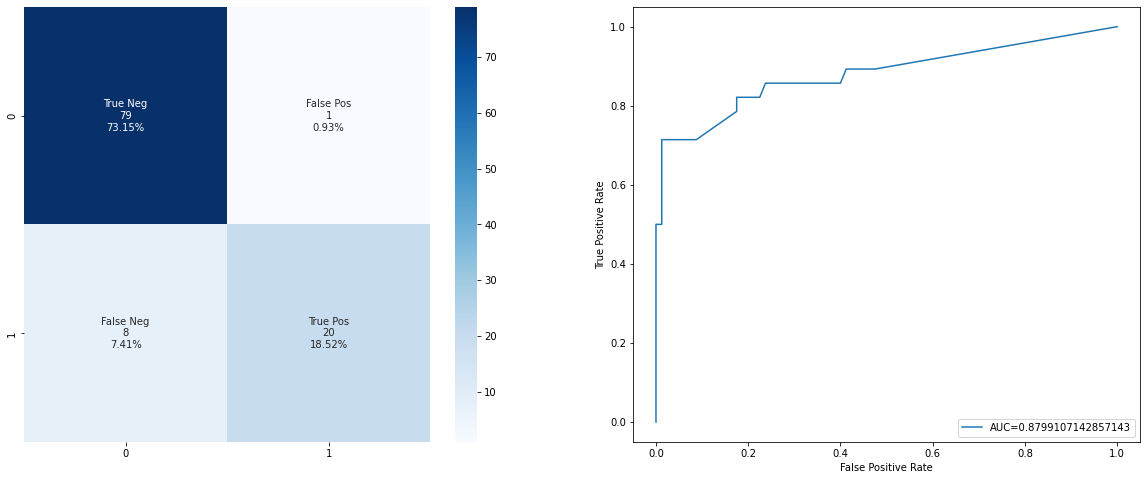

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        80
           1       0.95      0.71      0.82        28

    accuracy                           0.92       108
   macro avg       0.93      0.85      0.88       108
weighted avg       0.92      0.92      0.91       108



In [121]:
top_features = ['adj_kmer3_mean', 'adj_default_compound_max', 'smifp38Man_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [140]:
from sklearn.metrics import precision_recall_curve, auc


In [141]:
selected_features = []
best_aupr = 0  # Start with zero as the best AUPR

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred_proba = rf.predict_proba(X_test[temp_features])[:, 1]

        # Calculate precision-recall curve and AUPR
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        current_aupr = auc(recall, precision)

        # If this model is better, select this feature
        if current_aupr > best_aupr:
            best_aupr = current_aupr
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - AUPR: {best_aupr}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final_proba = rf_final.predict_proba(X_test[selected_features])[:, 1]

# Calculate final precision-recall curve and AUPR
precision_final, recall_final, _ = precision_recall_curve(y_test, y_pred_final_proba)
final_aupr = auc(recall_final, precision_final)
print(f"Final AUPR with selected features: {final_aupr}")

Added feature: adj_kmer3_mean - AUPR: 0.8253969116977364
Added feature: smifp34Man_max - AUPR: 0.8780944718343411
Added feature: HLCS_max - AUPR: 0.8959379055555698
Added feature: adj_default_protein_max - AUPR: 0.9129943600167132
Added feature: smifp38Tan_max - AUPR: 0.9254028819751785
Selected features: ['adj_kmer3_mean', 'smifp34Man_max', 'HLCS_max', 'adj_default_protein_max', 'smifp38Tan_max']
Final AUPR with selected features: 0.9254028819751785


Results of  NuclearReceptor 1:5 topFeatures2

 RandomForest ...................................

Accuracy: 0.8981481481481481
F1-Score: 0.7555555555555554
AUPRC: 0.9157529888536753
AUROC: 0.9345982142857143
PrecisionClass0: 0.8791208791208791
RecallClass0: 1.0
PrecisionClass1: 1.0
RecallClass1: 0.6071428571428571


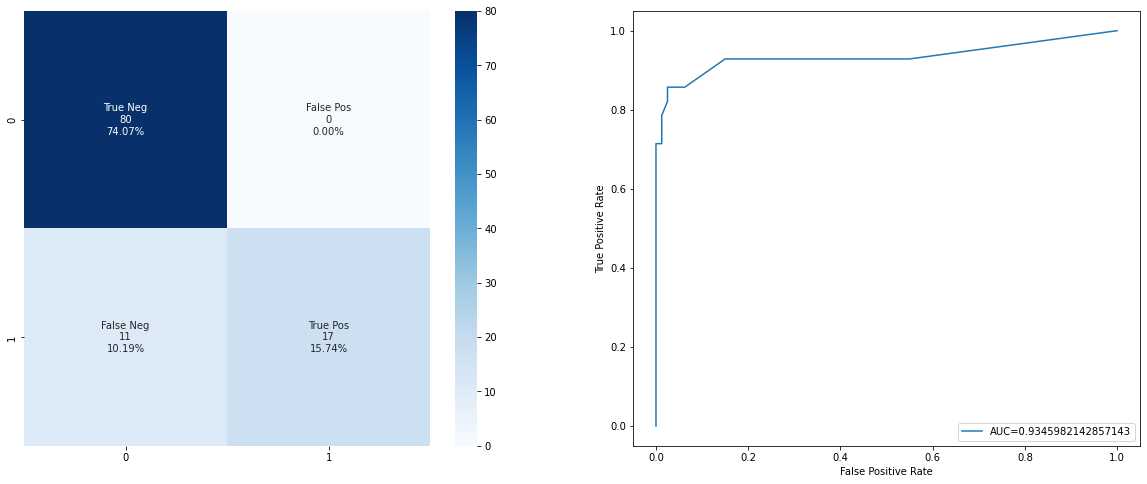

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        80
           1       1.00      0.61      0.76        28

    accuracy                           0.90       108
   macro avg       0.94      0.80      0.85       108
weighted avg       0.91      0.90      0.89       108



In [142]:
top_features = ['adj_kmer3_mean', 'smifp34Man_max', 'HLCS_max', 'adj_default_protein_max', 'smifp38Tan_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5 topFeatures2'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [143]:
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1
0,NuclearReceptor 1:1,0.954725,0.952160,0.842105,0.888889,0.882353,0.833333,0.861111,0.857143
1,NuclearReceptor 1:1 topFeatures,0.980914,0.983025,1.000000,0.888889,0.900000,1.000000,0.944444,0.947368
2,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
3,NuclearReceptor 1:5 topFeatures,0.831559,0.879911,0.908046,0.987500,0.952381,0.714286,0.916667,0.816327
4,NuclearReceptor 1:10,0.842116,0.971489,0.951613,0.994382,0.916667,0.550000,0.949495,0.687500
5,NuclearReceptor 1:10 topFeatures,0.872455,0.955056,0.967213,0.994382,0.933333,0.700000,0.964646,0.800000
6,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
7,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
8,NuclearReceptor 1:5 topFeatures2,0.915753,0.934598,0.879121,1.000000,1.000000,0.607143,0.898148,0.755556


<a name="3.3"></a>
### Ratio 1:10  
- [Evaluatuin](#3.3.0)
- [Feature Selection](#3.3.1)


In [122]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 10
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all


,index,Protein,Drug,Label
0,0,hsa6095,D00040,1
1,1,hsa2099,D00066,1
2,2,hsa5241,D00066,1
3,3,hsa2099,D00067,1
4,4,hsa367,D00075,1
...,...,...,...,...
985,985,hsa5915,D00577,0
986,986,hsa2100,D01132,0
987,987,hsa2101,D01132,0
988,988,hsa5468,D00143,0


In [123]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [124]:
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
#                                     "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,          
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])


for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
#     comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
#     comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0

    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
#         comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
#         comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
#                     comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores

990it [00:36, 27.09it/s]                                                                                                                                   


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00040,hsa6095,0.050847,0.050847,0.02863,0.028630,0.08500,0.085000,0.00000,...,0.085,0.0,0.0,0.064516,0.128205,0.030303,0.0,0.0,0.01333,0.29333
1,1,D00066,hsa2099,0.417582,0.246040,0.34623,0.149146,0.70110,0.397667,0.46736,...,5.16967,2.41853,6.37133,3.882961,6.094105,4.048077,3.38377,2.867113,1.31663,8.57231
2,2,D00066,hsa5241,0.641026,0.372632,0.43944,0.258838,0.95455,0.644480,0.52180,...,3.86688,2.12063,4.48172,3.08938,3.961927,3.197033,2.81709,2.420516,1.28436,4.99654
3,3,D00067,hsa2099,0.689189,0.343301,0.81070,0.291311,0.88926,0.483772,0.89957,...,6.28904,4.39152,7.67075,5.508455,7.280781,5.643084,5.19431,4.771251,0.89854,8.61926
4,4,D00075,hsa367,0.476190,0.251129,0.22883,0.136232,0.63519,0.374500,0.28841,...,1.8725,0.70043,2.22177,1.539641,2.308554,1.593518,1.31038,1.070378,0.40028,2.89239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,985,D00577,hsa5915,0.198113,0.131464,0.15592,0.108955,0.43554,0.305610,0.07221,...,0.61122,0.14036,0.28124,0.302562,0.718734,0.297971,0.12195,0.060606,0.12941,1.12112
986,986,D01132,hsa2100,0.198113,0.170056,0.15592,0.107890,0.43554,0.294527,0.08803,...,0.88358,0.20493,0.58487,0.606529,1.077833,0.464354,0.25246,0.157815,0.18391,1.36502
987,987,D01132,hsa2101,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
988,988,D00143,hsa5468,0.053892,0.046030,0.04035,0.029630,0.11548,0.084820,0.00255,...,0.16964,0.00255,0.04835,0.051432,0.313433,0.095239,0.01498,0.006944,0.03454,0.60894


Results of  NuclearReceptor 1:10

 RandomForest ...................................

Accuracy: 0.9494949494949495
F1-Score: 0.6874999999999999
AUPRC: 0.8421161821463787
AUROC: 0.9714887640449438
PrecisionClass0: 0.9516129032258065
RecallClass0: 0.9943820224719101
PrecisionClass1: 0.9166666666666666
RecallClass1: 0.55


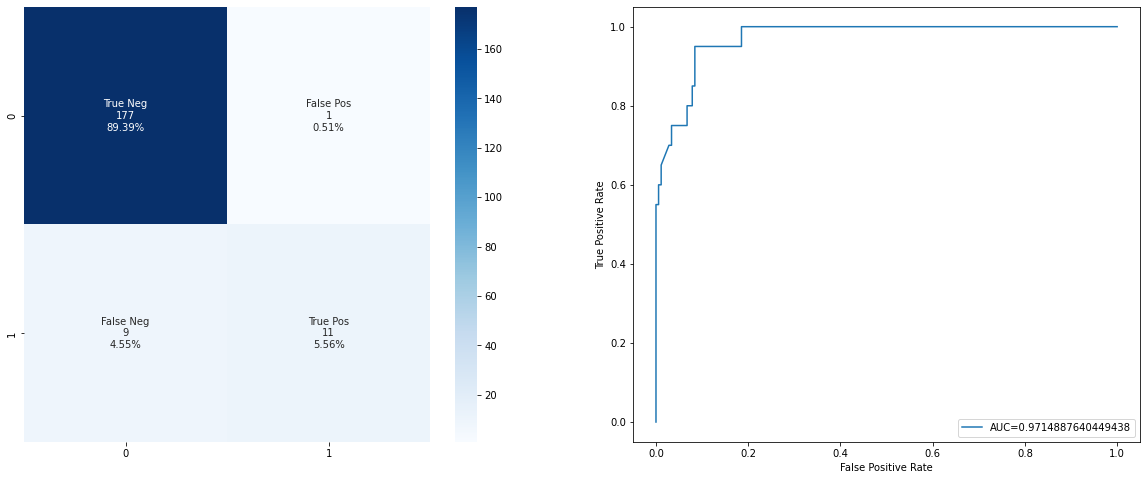

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       178
           1       0.92      0.55      0.69        20

    accuracy                           0.95       198
   macro avg       0.93      0.77      0.83       198
weighted avg       0.95      0.95      0.94       198



In [125]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'edit_max', 'edit_mean', 'lingo3_max', 'lingo3_mean',
       'lingo4_max', 'lingo4_mean', 'lingo5_max', 'lingo5_mean',
       'smifp34Man_max', 'smifp34Man_mean', 'smifp34Tan_max',
       'smifp34Tan_mean', 'smifp38Man_max', 'smifp38Man_mean',
       'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max', 'substring_mean',
       'target_align_score_max', 'target_align_score_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_NT_max', 'adj_default_protein_max',
       'adj_default_compound_max', 'adj_HLCS_max', 'adj_NLCS_max',
       'adj_TFIDF_simmat_max', 'adj_TF_simmat_max', 'adj_complingo_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:10'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list


<a name="3.3.1"></a>
**Feature Selection**

In [126]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: TFIDF_simmat_max - Accuracy: 0.9292929292929293
Added feature: adj_kmer3_max - Accuracy: 0.9545454545454546
Added feature: NT_mean - Accuracy: 0.9595959595959596
Added feature: NLCS_max - Accuracy: 0.9646464646464646
Selected features: ['TFIDF_simmat_max', 'adj_kmer3_max', 'NT_mean', 'NLCS_max']
Final Accuracy with selected features: 0.9646464646464646


Results of  NuclearReceptor 1:10 topFeatures

 RandomForest ...................................

Accuracy: 0.9646464646464646
F1-Score: 0.8
AUPRC: 0.8724552547915927
AUROC: 0.9550561797752808
PrecisionClass0: 0.9672131147540983
RecallClass0: 0.9943820224719101
PrecisionClass1: 0.9333333333333333
RecallClass1: 0.7


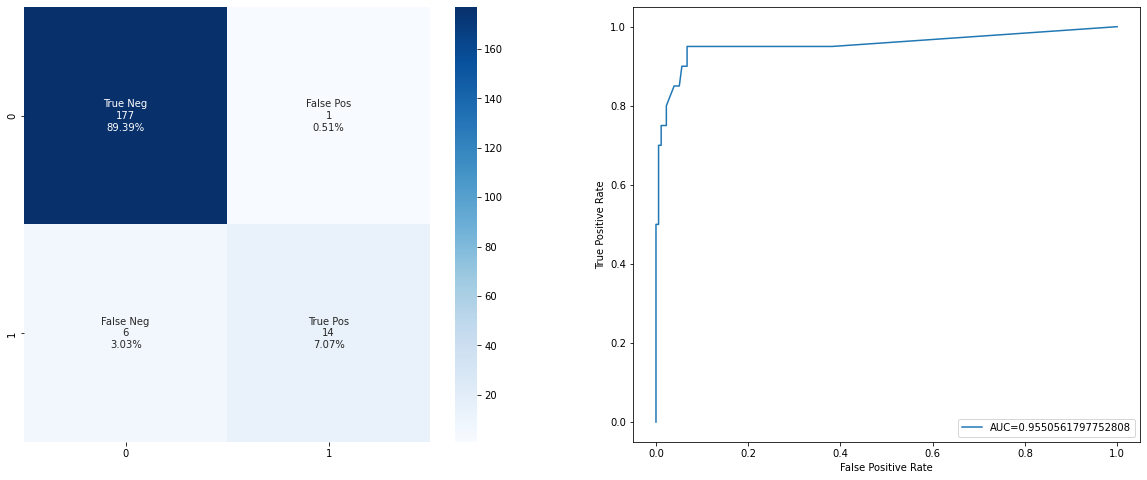

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       178
           1       0.93      0.70      0.80        20

    accuracy                           0.96       198
   macro avg       0.95      0.85      0.89       198
weighted avg       0.96      0.96      0.96       198



In [127]:
top_features = ['TFIDF_simmat_max', 'adj_kmer3_max', 'NT_mean', 'NLCS_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:10 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [128]:
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1
0,NuclearReceptor 1:1,0.954725,0.952160,0.842105,0.888889,0.882353,0.833333,0.861111,0.857143
1,NuclearReceptor 1:1 topFeatures,0.980914,0.983025,1.000000,0.888889,0.900000,1.000000,0.944444,0.947368
2,NuclearReceptor 1:5,0.842933,0.897545,0.886364,0.975000,0.900000,0.642857,0.888889,0.750000
3,NuclearReceptor 1:5 topFeatures,0.831559,0.879911,0.908046,0.987500,0.952381,0.714286,0.916667,0.816327
4,NuclearReceptor 1:10,0.842116,0.971489,0.951613,0.994382,0.916667,0.550000,0.949495,0.687500
5,NuclearReceptor 1:10 topFeatures,0.872455,0.955056,0.967213,0.994382,0.933333,0.700000,0.964646,0.800000


In [ ]:
features_NR_10 = ['TFIDF_simmat_max', 'adj_kmer3_max', 'NT_mean', 'NLCS_max']

features_NR_5 = ['adj_kmer3_mean', 'smifp34Man_max', 'HLCS_max', 'adj_default_protein_max', 'smifp38Tan_max']

features_NR_1 = ['kmer4_mean', 'smifp38Tan_max']

## Case Study

In [161]:
mapping

,Protein,Drug
0,hsa6095,D00040
1,hsa2099,D00066
2,hsa5241,D00066
3,hsa2099,D00067
4,hsa367,D00075
...,...,...
85,hsa2099,D02367
86,hsa5241,D02367
87,hsa2099,D04066
88,hsa2100,D04066


In [162]:
from itertools import product
# Extract unique proteins and drugs
unique_proteins = mapping['Protein'].unique()
unique_drugs = mapping['Drug'].unique()

# Generate all possible combinations
all_combinations = list(product(unique_proteins, unique_drugs))

# Check if each combination is in the original DataFrame
combination_labels = [
    (protein, drug, 1 if not mapping[(mapping['Protein'] == protein) & (mapping['Drug'] == drug)].empty else 0)
    for protein, drug in all_combinations
]

# Create the new DataFrame
new_df = pd.DataFrame(combination_labels, columns=['Protein', 'Drug', 'Label'])
new_df

,Protein,Drug,Label
0,hsa6095,D00040,1
1,hsa6095,D00066,0
2,hsa6095,D00067,0
3,hsa6095,D00075,0
4,hsa6095,D00088,0
...,...,...,...
1399,hsa3174,D01689,0
1400,hsa3174,D02217,0
1401,hsa3174,D02367,0
1402,hsa3174,D04066,0


In [164]:
new_df['Label'].value_counts()

0    1314
1      90
Name: Label, dtype: int64

In [174]:
new_df = new_df.reset_index()

In [175]:
unknown  = new_df[new_df['Label'] == 0]
positive = new_df[new_df['Label'] == 1]
#Negative
negative_df = unknown.sample(n=90, replace=True, random_state=1)
concatenated_df = pd.concat([positive, negative_df], ignore_index=True)
#Split Dataset
train_mapping, test_mapping = train_test_split(concatenated_df, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [176]:
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                   'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
#                                     "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,          
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])



for index, row in tqdm(new_df.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
#     comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
#     comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0

    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
#         comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
#         comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
#                     comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']

df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores


1404it [02:25,  9.67it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00040,hsa6095,0.050847,0.050847,0.02863,0.028630,0.08500,0.085000,0.00000,...,0.085,0.0,0.0,0.064516,0.128205,0.030303,0.0,0.0,0.01333,0.29333
1,1,D00066,hsa6095,0.378641,0.226820,0.28333,0.161685,0.70838,0.411705,0.30595,...,0.82341,0.3095,0.75756,0.560698,0.92255,0.569846,0.43559,0.415457,0.08254,1.19863
2,2,D00067,hsa6095,0.216216,0.161799,0.12049,0.080635,0.33231,0.226565,0.10160,...,0.45313,0.1201,0.61075,0.382086,0.628556,0.379861,0.25119,0.220886,0.05208,1.09968
3,3,D00075,hsa6095,0.412371,0.238033,0.17953,0.101630,0.51303,0.289505,0.19896,...,0.57901,0.20128,0.71282,0.495632,0.675448,0.495618,0.35475,0.306621,0.07469,1.17118
4,4,D00088,hsa6095,0.262712,0.170513,0.16889,0.100360,0.48666,0.288130,0.21159,...,0.57626,0.22673,0.74324,0.497001,0.594595,0.547476,0.40121,0.315349,0.07521,1.20582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,1399,D01689,hsa3174,0.061069,0.061069,0.08486,0.084860,0.24706,0.247060,0.00000,...,0.24706,0.0,0.0,0.031915,0.247059,0.039506,0.0,0.0,0.02632,0.18635
1400,1400,D02217,hsa3174,0.041379,0.041379,0.03676,0.036760,0.06888,0.068880,0.06907,...,0.06888,0.06907,0.12521,0.022173,0.142857,0.032213,0.00513,0.002797,0.02381,0.27333
1401,1401,D02367,hsa3174,0.035714,0.035714,0.09501,0.095010,0.26447,0.264470,0.09220,...,0.26447,0.0922,0.09084,0.026966,0.292308,0.056022,0.00265,0.0,0.03846,0.24322
1402,1402,D04066,hsa3174,0.072581,0.072581,0.06863,0.068630,0.20238,0.202380,0.00000,...,0.20238,0.0,0.0,0.059524,0.25,0.0,0.0,0.0,0.03846,0.26414


In [177]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

Results of  NuclearReceptor 1:5

 RandomForest ...................................

Accuracy: 0.9444444444444444
F1-Score: 0.9473684210526316
AUPRC: 0.9880900508351489
AUROC: 0.9876543209876544
PrecisionClass0: 1.0
RecallClass0: 0.8888888888888888
PrecisionClass1: 0.9
RecallClass1: 1.0


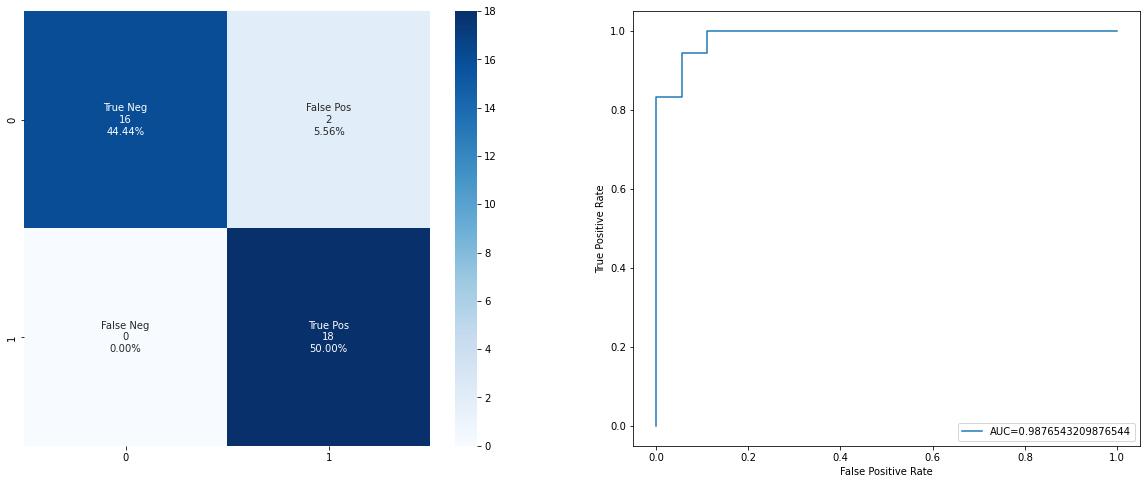

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.90      1.00      0.95        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



In [185]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'edit_max', 'edit_mean', 'lingo3_max', 'lingo3_mean',
       'lingo4_max', 'lingo4_mean', 'lingo5_max', 'lingo5_mean',
       'smifp34Man_max', 'smifp34Man_mean', 'smifp34Tan_max',
       'smifp34Tan_mean', 'smifp38Man_max', 'smifp38Man_mean',
       'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max', 'substring_mean',
       'target_align_score_max', 'target_align_score_mean', 'kmer4_max',
       'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max', 'kmer2_mean',
       'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_NT_max', 'adj_default_protein_max',
       'adj_default_compound_max', 'adj_HLCS_max', 'adj_NLCS_max',
       'adj_TFIDF_simmat_max', 'adj_TF_simmat_max', 'adj_complingo_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_smile_mean',
       'adj_sequence_mean', 'adj_kmer1_mean', 'adj_kmer2_mean',
       'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [188]:
y_prob

array([0.862, 0.738, 0.972, 0.938, 0.984, 0.93 , 0.574, 0.076, 0.566,
       0.934, 0.08 , 0.058, 0.036, 0.784, 0.01 , 0.988, 0.988, 0.924,
       0.938, 0.004, 0.018, 0.958, 0.36 , 0.194, 0.678, 0.692, 0.994,
       0.432, 0.01 , 0.91 , 0.712, 0.066, 0.022, 0.032, 0.138, 0.002])

In [187]:
unknown_df =  df_scores[df_scores['index'].isin(unknown['index'].tolist())]
unknown_df

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
1,1,D00066,hsa6095,0.378641,0.226820,0.28333,0.161685,0.70838,0.411705,0.30595,...,0.82341,0.3095,0.75756,0.560698,0.92255,0.569846,0.43559,0.415457,0.08254,1.19863
2,2,D00067,hsa6095,0.216216,0.161799,0.12049,0.080635,0.33231,0.226565,0.10160,...,0.45313,0.1201,0.61075,0.382086,0.628556,0.379861,0.25119,0.220886,0.05208,1.09968
3,3,D00075,hsa6095,0.412371,0.238033,0.17953,0.101630,0.51303,0.289505,0.19896,...,0.57901,0.20128,0.71282,0.495632,0.675448,0.495618,0.35475,0.306621,0.07469,1.17118
4,4,D00088,hsa6095,0.262712,0.170513,0.16889,0.100360,0.48666,0.288130,0.21159,...,0.57626,0.22673,0.74324,0.497001,0.594595,0.547476,0.40121,0.315349,0.07521,1.20582
5,5,D00094,hsa6095,0.113821,0.092167,0.06535,0.049075,0.18440,0.139415,0.09209,...,0.27883,0.10004,0.12269,0.172966,0.500351,0.174284,0.07071,0.034483,0.04977,0.6795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398,1398,D01441,hsa3174,0.032468,0.032468,0.02174,0.021740,0.05284,0.052840,0.02249,...,0.05284,0.02249,0.03972,0.024706,0.123288,0.050847,0.01493,0.0,0.01852,0.17574
1399,1399,D01689,hsa3174,0.061069,0.061069,0.08486,0.084860,0.24706,0.247060,0.00000,...,0.24706,0.0,0.0,0.031915,0.247059,0.039506,0.0,0.0,0.02632,0.18635
1400,1400,D02217,hsa3174,0.041379,0.041379,0.03676,0.036760,0.06888,0.068880,0.06907,...,0.06888,0.06907,0.12521,0.022173,0.142857,0.032213,0.00513,0.002797,0.02381,0.27333
1401,1401,D02367,hsa3174,0.035714,0.035714,0.09501,0.095010,0.26447,0.264470,0.09220,...,0.26447,0.0922,0.09084,0.026966,0.292308,0.056022,0.00265,0.0,0.03846,0.24322


In [190]:
# Make predictions
y_prob_unknown = rf.predict_proba(unknown_df[features])[:, 1]
# Create DataFrame with training data and predictions
train_with_predictions = unknown_df.copy()
train_with_predictions['prediction'] = y_prob_unknown

In [195]:
train_with_predictions.sort_values("prediction",ascending=False).head(20)[["drugID" , "targetID","prediction"]]

,drugID,targetID,prediction
76,D00462,hsa2099,1.000
226,D00182,hsa2908,1.000
130,D00462,hsa5241,0.998
64,D00182,hsa2099,0.996
172,D00182,hsa367,0.994
238,D00462,hsa2908,0.988
789,D00898,hsa2100,0.944
99,D01217,hsa2099,0.942
1167,D00898,hsa2101,0.940
1275,D00898,hsa2104,0.940
